<a href="https://colab.research.google.com/github/AstroNoodles/Mini-Projects/blob/master/Train_Stations_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train Stations Notebook

We want to find the minimal amount of transfers between two MTA stations which we can eventually reapply into an app n the future. We can do this via: http://web.mta.info/developers/data/nyct/subway/Stations.csv

The main parts of the csv file we may need to use are the station ID, division, stop name and daytime routes. We need to create a graph which connects the subway stations together so we can use breadth-first search to find the shortest route between the two routes.

Let's do some basic data preprocessing and visualization before we do this and import our modules!

In [0]:
import pandas as pd
from collections import deque, defaultdict
import matplotlib.pyplot as plt
import matplotlib.image as mimg

%matplotlib inline

In [0]:
# Read the csv file
dataset = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

In [17]:
dataset.head(5)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude
0,1,1,R01,BMT,Astoria,Astoria - Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575


# Preprocessing

For data preprocessing, I renamed some of the trains and some of the rows to make it clearer and to save some typing for later. :-)

In [0]:
# Replace the long shuttle trains with the label S

for index, row in dataset.iterrows():
    if row['Line'] == 'Franklin Ave Shuttle':
        dataset.at[index, "Daytime Routes"] = 'Fr_S'
    elif row['Line'] == 'Lexington - Shuttle':
        dataset.at[index, 'Daytime Routes'] = 'Lex_S'

dataset = dataset.iloc[:len(dataset)-1]

In [19]:
# Rename the long feature names with simple ones (id, lat, long)

kstops = dataset.drop(['Complex ID', 'Division', 'GTFS Stop ID', 'Line', 'Structure'], axis=1)
kstops.rename(index=str,columns={"GTFS Latitude" : "Lat", 'GTFS Longitude': "Long", "Station ID": "id"}, inplace=True)
kstops.head(10)

,id,Stop Name,Borough,Daytime Routes,Lat,Long
0,1,Astoria - Ditmars Blvd,Q,N W,40.775036,-73.912034
1,2,Astoria Blvd,Q,N W,40.770258,-73.917843
2,3,30 Av,Q,N W,40.766779,-73.921479
3,4,Broadway,Q,N W,40.761820,-73.925508
4,5,36 Av,Q,N W,40.756804,-73.929575
5,6,39 Av,Q,N W,40.752882,-73.932755
6,7,Lexington Av/59 St,M,N W R,40.762660,-73.967258
7,8,5 Av/59 St,M,N W R,40.764811,-73.973347
8,9,57 St - 7 Av,M,N Q R W,40.764664,-73.980658
9,10,49 St,M,N R W,40.759901,-73.984139


In [20]:
trains_stops = kstops[['Stop Name', 'Daytime Routes', 'Borough']]
trains_stops[10:20]

,Stop Name,Daytime Routes,Borough
10,Times Sq - 42 St,N Q R W,M
11,34 St - Herald Sq,N Q R W,M
12,28 St,R W,M
13,23 St,R W,M
14,14 St - Union Sq,N Q R W,M
15,8 St - NYU,R W,M
16,Prince St,R W,M
17,Canal St,R W,M
18,Canal St,N Q,M
19,City Hall,R W,M


In [21]:
for index, row in trains_stops[:5].iterrows():
    print(index, row['Stop Name'], row['Daytime Routes'])

0 Astoria - Ditmars Blvd N W
1 Astoria Blvd N W
2 30 Av N W
3 Broadway N W
4 36 Av N W


# Collective Procedures

Now, I collected the train stops and attempted to pair them together.

In [22]:
# Split the trains individually and gather them
nyc_trains = []

trains = trains_stops['Daytime Routes']
for many_trains in trains: # For the N W in the columns
    train_list = many_trains.split(" ") # Split the N W into ['N', 'W']
    for train in train_list: # For each char in ['N', 'W']
        nyc_trains.append(train) # add it to the list

nyc_trains = sorted(list(set(nyc_trains)))
print(nyc_trains)

['1', '2', '3', '4', '5', '6', '7', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'J', 'L', 'Lex_S', 'M', 'N', 'Q', 'R', 'S', 'SIR', 'W', 'Z']


In [23]:
# Gather all the stops made by a single train
train_to_stops = defaultdict(list)
stop_collisions = []

for train in nyc_trains:
    for index, row in trains_stops.iterrows():
        if train in row['Daytime Routes'].split(" "):
#           if row['Stop Name'] not in stop_collisions:
#             train_to_stops[train] += [row['Stop Name']]
#             stop_collisions.append(row['Stop Name'])
#           else:
#             train_to_stops[train] += [f"{row['Stop Name']}  {row['Line']}"]
            train_to_stops[train] += [f"{row['Stop Name']}"]
train_to_stops

defaultdict(list,
            {'1': ['Van Cortlandt Park - 242 St',
              '238 St',
              '231 St',
              'Marble Hill - 225 St',
              '215 St',
              '207 St',
              'Dyckman St',
              '191 St',
              '181 St',
              '168 St - Washington Hts',
              '157 St',
              '145 St',
              '137 St - City College',
              '125 St',
              '116 St - Columbia University',
              'Cathedral Pkwy',
              '103 St',
              '96 St',
              '86 St',
              '79 St',
              '72 St',
              '66 St - Lincoln Center',
              '59 St - Columbus Circle',
              '50 St',
              'Times Sq - 42 St',
              '34 St - Penn Station',
              '28 St',
              '23 St',
              '18 St',
              '14 St',
              'Christopher St - Sheridan Sq',
              'Houston St',
              'Canal St',
        

In [24]:
stops = trains_stops['Stop Name']
stops_to_transfers = defaultdict(list)

for index, row in trains_stops.iterrows():
    stops_to_transfers[stops[index]] += trains_stops.loc[index, 'Daytime Routes'].split(" ")

stops_to_transfers

defaultdict(list,
            {'1 Av': ['L'],
             '103 St': ['B', 'C', '1', '6'],
             '103 St - Corona Plaza': ['7'],
             '104 St': ['J', 'Z', 'A'],
             '110 St': ['6'],
             '111 St': ['J', 'A', '7'],
             '116 St': ['B', 'C', '6', '2', '3'],
             '116 St - Columbia University': ['1'],
             '121 St': ['J', 'Z'],
             '125 St': ['A', 'B', 'C', 'D', '1', '4', '5', '6', '2', '3'],
             '135 St': ['B', 'C', '2', '3'],
             '137 St - City College': ['1'],
             '138 St - Grand Concourse': ['4', '5'],
             '14 St': ['A', 'C', 'E', 'F', 'M', '1', '2', '3'],
             '14 St - Union Sq': ['N', 'Q', 'R', 'W', '4', '5', '6'],
             '145 St': ['A', 'C', 'B', 'D', '1', '3'],
             '149 St - Grand Concourse': ['4', '2', '5'],
             '15 St - Prospect Park': ['F', 'G'],
             '155 St': ['C', 'B', 'D'],
             '157 St': ['1'],
             '161 St - Yankee St

# Visualization

Some brief visualization of the dataset. 
* First,  I want to get a picture of NYC from my Google Drive using PyDrive 
* Then, we can place it as the background to the latitude vs. longitude scatter plot that can formed out of the data.

Text(0.5, 1.0, 'Longitude vs. Latitude - Train Stop Locations')

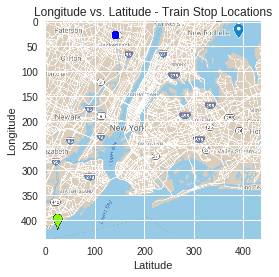

In [38]:
# Basic Data Visualization

nyc_map = mimg.imread('https://raw.githubusercontent.com/AstroNoodles/Mini-Projects/master/Data%20Science/nyc_map.png')
plt.imshow(nyc_map)
plt.plot(kstops['Lat'] + 100, kstops['Long'] + 100, 'bo') # ???

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Longitude vs. Latitude - Train Stop Locations')

# Breadth-First Search and Goal Accomplishment (WIP)

Now to accomplish the breadth first search and complete the goal of the notebook!

In [0]:
def bfs(goal: str, start: str, dataset: dict):
    dq = deque()
    dq += dataset[start]
    visited = []
    while goal not in visited:
        item = dq.popleft()
        if item not in visited:
            print(item)
            visited.append(item)
    return visited

In [27]:
bfs('Pelham Pkwy', 'Hewes St', stops_to_transfers)
# HELP?

J
M


IndexError: ignored